In [2]:
import logging
import numpy as np
import pandas as pd
import h5py as h5
from collections import namedtuple
import matplotlib.pyplot as plt
import datetime as dt

# Load Data

Load from one file

In [8]:
datadir = 'data/jz7w/evensplitlayers/'
infile = 'endcap.h5'

logging.info(f'Loading data from data/{infile}')

with h5.File(datadir+infile, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

### Exploring data structure

In [9]:
outDir = 'output/sample_distributions/'+infile.split('.')[0]+'/'
if not os.path.exists(outDir):
    os.mkdir(outDir)

EndcapMask = data_x[:,57]!=0
BarrelMask = np.logical_and(data_x[:,56]!=0, data_x[:,57]==0)
IBLMask = np.logical_and(data_x[:,56]==0, data_x[:,57]==0)

data_y_copy = np.copy(data_y)
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]

Plot layer distribution

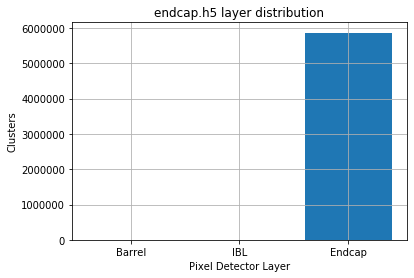

In [10]:
zeros = np.empty((data_x.shape[0], 1))
hist = [zeros[BarrelMask].shape[0], zeros[IBLMask].shape[0], zeros[EndcapMask].shape[0]]
bins = ['Barrel', 'IBL', 'Endcap']

plt.bar(bins, hist)
plt.ylabel(f"Clusters")
plt.xlabel(f"Pixel Detector Layer")
plt.grid(True)
plt.title(f'{infile} layer distribution')
plt.savefig(f'{outDir}{infile}_layer_distribution.png')
plt.show()
plt.close()

plot total label distribution

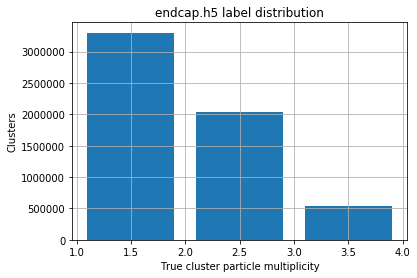

In [11]:
hist = np.histogram(data_y_copy, bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} label distribution')
plt.savefig(f'{outDir}{infile}_label_distribution.png')
plt.show()
plt.close()

Plot label distribution for each layer

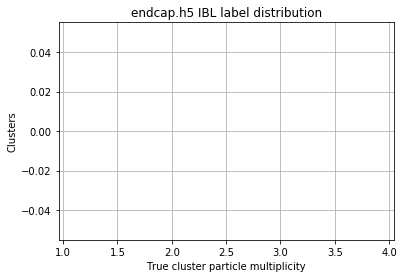

In [12]:
hist = np.histogram(data_y_copy[IBLMask], bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} IBL label distribution')
plt.savefig(f'{outDir}{infile}_IBL_label_distribution.png')
plt.show()
plt.close()

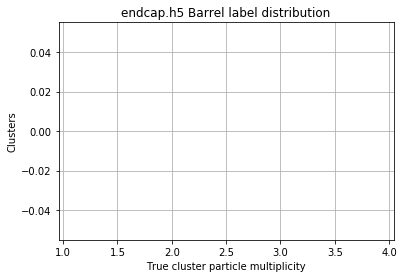

In [13]:
hist = np.histogram(data_y_copy[BarrelMask], bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} Barrel label distribution')
plt.savefig(f'{outDir}{infile}_Barrel_label_distribution.png')
plt.show()
plt.close()

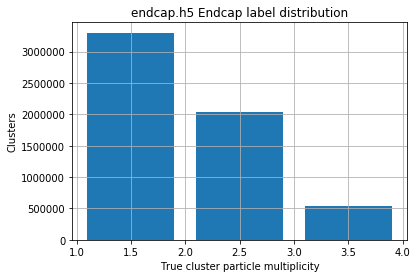

In [14]:
hist = np.histogram(data_y_copy[EndcapMask], bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} Endcap label distribution')
plt.savefig(f'{outDir}{infile}_Endcap_label_distribution.png')
plt.show()
plt.close()

# Load, shuffle, and save endcap, barrel, ibl files

In [1]:
datadir = 'data/jz7w/evensplitlayers/'
layerFiles = ['barrel10Mequalfraction', 'ibl10Mequalfraction', 'endcap10Mequalfraction']

layer_clusters = 1e7

In [3]:
for i, layerFile in enumerate(layerFiles):
    rng = np.random.default_rng(seed=42)
    logging.info('Shuffling {}.h5')
    with h5.File('{}{}.h5'.format(datadir, layerFile), 'r') as data:
        data_x = data['input'][()]
        data_y = data['target'][()]

    s = np.arange(data_x.shape[0])
    rng.shuffle(s)
    data_x = data_x[s]
    data_y = data_y[s]

    logging.info('Saving {}_shuffled.h5')
    with h5.File('{}{}_shuffled.h5'.format(datadir, layerFile), 'w') as hfile:
        hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
        hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')


Load 4M clusters from each layer for training, save sample for training

In [4]:
data_x = np.empty((0,data_x.shape[1]))
data_y = np.empty((0,data_y.shape[1]))
for i, layerFile in enumerate(layerFiles):
    logging.info('Loading clusters from {}_shuffled.h5')
    with h5.File('{}{}_shuffled.h5'.format(datadir, layerFile), 'r') as data:
        data_x = np.append(data_x, data['input'][:layer_clusters-1], axis=0)
        data_y = np.append(data_y, data['target'][:layer_clusters-1], axis=0)

infile = '814_evensplit_equalfrac_train.h5'
with h5.File('data/{}'.format(infile), 'w') as hfile:
    hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

TypeError: slice indices must be integers or None or have an __index__ method

# Load, Shuffle, and Balance Data then Save

In [16]:
datadir = 'data/jz7w/evensplitlayers/'
infile = 'endcap.h5'

logging.info(f'Loading data from data/{infile}')

with h5.File(datadir+infile, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

layer_clusters = 1e7
label_layerClusters = int(layer_clusters/3)

In [17]:
logging.info('Shuffling')
rng = np.random.default_rng(seed=42)
s = np.arange(data_x.shape[0])
rng.shuffle(s)

data_x = data_x[s]
data_y = data_y[s]

In [18]:
EndcapMask = data_x[:,57]!=0
BarrelMask = np.logical_and(data_x[:,56]!=0, data_x[:,57]==0)
IBLMask = np.logical_and(data_x[:,56]==0, data_x[:,57]==0)

data_y_copy = np.copy(data_y)
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]

particleMask = [data_y_copy == 1, data_y_copy == 2, data_y_copy == 3]

In [19]:
data_y_copy = np.copy(data_y)
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]
hist = np.histogram(data_y_copy, bins=[0,1.5,2.5,3.5])
hist

(array([3300000, 2037431,  531143], dtype=int64), array([0. , 1.5, 2.5, 3.5]))

In [20]:
addPerLabel = [label_layerClusters - i for i in hist[0]]
addPerLabel

[33333, 1295902, 2802190]

In [22]:
data_x_new = np.empty((0,data_x.shape[1]))
data_y_new = np.empty((0,data_y.shape[1]))
for i,add in enumerate(addPerLabel):
    if add <= 0:
        data_x_new = np.append(data_x_new, data_x[particleMask[i]][:label_layerClusters], axis=0)
        data_y_new = np.append(data_y_new, data_y[particleMask[i]][:label_layerClusters], axis=0)
    else:
        add_index = np.remainder(np.array(range(label_layerClusters)), np.array(data_x[particleMask[i]].shape[0]))
        data_x_new = np.append(data_x_new, data_x[particleMask[i]][add_index], axis=0)
        data_y_new = np.append(data_y_new, data_y[particleMask[i]][add_index], axis=0)


In [23]:
data_x = data_x_new
data_y = data_y_new

In [24]:
outfile = datadir+'endcap10Mequalfraction.h5'

with h5.File(outfile, 'w') as hfile:
    hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

# Create Train and Test splits

In [24]:
outtrain = 'jz7w_evensplit_train.h5'
outtest = 'jz7w_evensplit_test.h5'

with h5.File('data/'+outtrain, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[train_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[train_split].astype(np.float32), compression='gzip')

with h5.File('data/'+outtest, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[test_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[test_split].astype(np.float32), compression='gzip')

# Create 10 Splits

In [20]:
for i in range(10):
    with h5.File(f'data/split{i+1}.h5', 'w') as hfile:
        hfile.create_dataset('input', data=data_x[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
        hfile.create_dataset('target', data=data_y[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
